# Model Experimentation

En este notebook se experimentará con tres enfoques distintos para predecir la demanda 
a nivel **día/producto/transacción**. Los modelos a evaluar son:

1. **Random Forest** → Modelo de machine learning.
2. **LightGBM** → Modelo de machine learning.
3. **CatBoost** → Modelo de machine learning.

El objetivo es comparar su desempeño usando métricas de error 
(MAE, RMSE) y seleccionar el mejor modelo para integrarlo en el pipeline 
de entrenamiento y predicción.

In [ ]:
import pandas as pd
# Cargar parquet y filtrar datos

df_training = pd.read_parquet("../data/processed/data_training.parquet")

# Filtrar outliers y productos con suficiente historial
df_filtered = df_training[df_training["units_sold"] <= 20].copy()
product_counts = df_filtered["product_sku"].value_counts()
products_50plus = product_counts[product_counts >= 50].index
df_filtered = df_filtered[df_filtered["product_sku"].isin(products_50plus)]

#Definir features

from sklearn.preprocessing import LabelEncoder

available_features = [
    "year", "month", "day", "dayofweek", "is_weekend", 
    "is_month_start", "is_month_end", "month_sin", "month_cos",
    "dayofweek_sin", "dayofweek_cos", "product_units_lag_1",
    "product_units_lag_3", "product_units_lag_7", "product_units_lag_14",
    "product_units_rolling_mean_7", "product_units_rolling_mean_30",
    "product_units_trend_7", "days_since_last_transaction"
]

available_features = [col for col in available_features if col in df_filtered.columns]

# Codificación producto
le = LabelEncoder()
df_filtered["product_sku_encoded"] = le.fit_transform(df_filtered["product_sku"])
available_features.append("product_sku_encoded")



### Experimento 1 - Random Forest

In [18]:
# ------------------------------
# EXPERIMENTO 1 - RANDOM FOREST
# ------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt  

print("ENTRENANDO RANDOM FOREST")

ENTRENANDO RANDOM FOREST


In [19]:
# 1. Ordenar datos por fecha y dividir en train/test
df_sorted = df_filtered.sort_values("parsed_date")
split_date = df_sorted["parsed_date"].quantile(0.8)

train_mask = df_sorted["parsed_date"] <= split_date
test_mask = df_sorted["parsed_date"] > split_date

X_train = df_sorted.loc[train_mask, available_features]
X_test = df_sorted.loc[test_mask, available_features]
y_train = df_sorted.loc[train_mask, "units_sold"]
y_test = df_sorted.loc[test_mask, "units_sold"]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 14121, Test: 3495


In [20]:
# 2. Entrenar modelo
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [21]:
# 3. Predicciones
y_pred = rf.predict(X_test)

In [25]:
# 4. Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RESULTADOS RANDOM FOREST")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")


RESULTADOS RANDOM FOREST
MAE  : 3.04
RMSE : 4.22


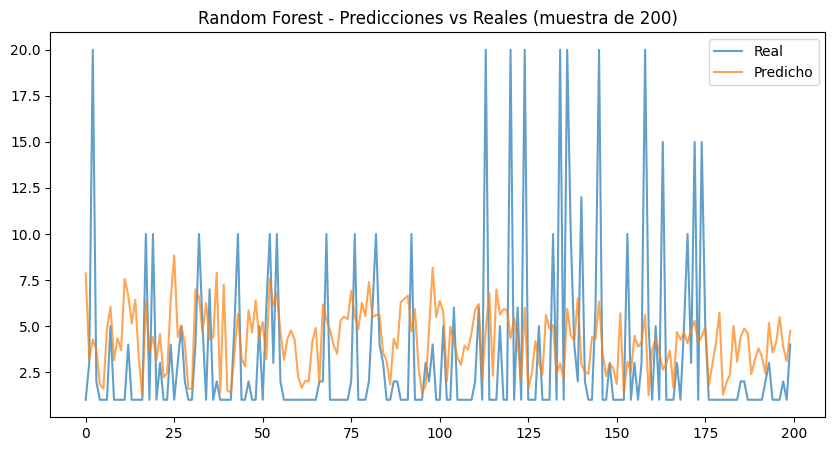

In [23]:
# 5. Visualización predicciones vs reales
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:200], label="Real", alpha=0.7)
plt.plot(y_pred[:200], label="Predicho", alpha=0.7)
plt.legend()
plt.title("Random Forest - Predicciones vs Reales (muestra de 200)")
plt.show()

### Conclusión: Experimento 1 - Random Forest

**Resultados obtenidos:**
- MAE  : ~3.04  
- RMSE : ~4.22  

**Observaciones:**
- El modelo logra predecir con un error promedio de unas **3 unidades por transacción**, lo cual es aceptable para el nivel de granularidad (día/producto/transacción).  
- El RMSE también es bajo, lo que indica que los errores grandes no son tan frecuentes.  
- Sin embargo, al ser un modelo basado en bagging, puede tener limitaciones para capturar patrones temporales complejos o dependencias largas en las series de cada producto.  


### Experimento 2 - LightGBM

In [27]:
# ------------------------------
# EXPERIMENTO 2 - LIGHTGBM
# ------------------------------
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt  

print("ENTRENANDO LIGHTGBM")

ENTRENANDO LIGHTGBM


In [28]:
# 1. DIVIDIR DATOS
df_sorted = df_filtered.sort_values("parsed_date")
split_date = df_sorted["parsed_date"].quantile(0.8)

train_mask = df_sorted["parsed_date"] <= split_date
test_mask = df_sorted["parsed_date"] > split_date

X_train = df_sorted.loc[train_mask, available_features]
X_test = df_sorted.loc[test_mask, available_features]
y_train = df_sorted.loc[train_mask, "units_sold"]
y_test = df_sorted.loc[test_mask, "units_sold"]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 14121, Test: 3495


In [29]:
# 2. MODELO LIGHTGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 14121, number of used features: 20
[LightGBM] [Info] Start training from score 3.392394


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
              n_jobs=-1, random_state=42, subsample=0.8)

In [30]:
# 3. PREDICCIONES
y_pred_lgb = lgb_model.predict(X_test)

In [34]:
# 4. MÉTRICAS
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print("RESULTADOS LIGHTGBM")
print(f"MAE  : {mae_lgb:.2f}")
print(f"RMSE : {rmse_lgb:.2f}")

RESULTADOS LIGHTGBM
MAE  : 2.84
RMSE : 4.22


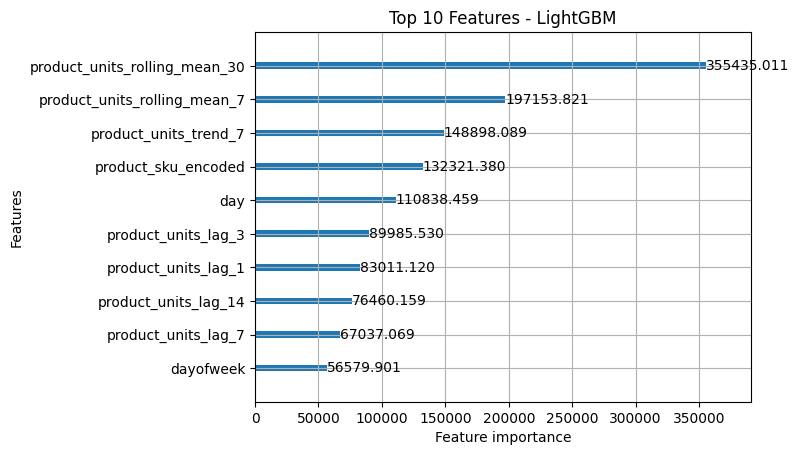

In [32]:
# 5. FEATURE IMPORTANCE
lgb.plot_importance(lgb_model, max_num_features=10, importance_type="gain")
plt.title("Top 10 Features - LightGBM")
plt.show()

### Conclusión: Experimento 2 - LightGBM

**Resultados obtenidos:**
- MAE  : ~2.84  
- RMSE : ~4.22  

**Observaciones:**
- LightGBM logra un **error promedio ligeramente menor** que Random Forest, indicando que las predicciones tienden a estar más cerca del valor real por transacción.  
- El RMSE se mantiene similar, lo que sugiere que los errores grandes no cambian significativamente respecto al modelo anterior.  
- La importancia de features muestra que las variables de **lags y rolling mean** son las más influyentes, confirmando que el historial de ventas es crítico para predecir la demanda a nivel día/producto.  
- LightGBM es **rápido y eficiente**, y se adapta bien a datos granulares, lo que lo hace un buen candidato para el pipeline de predicción.


### Experimento 3 - CatBoost

In [36]:
# ------------------------------
# EXPERIMENTO 3 - CATBOOST
# ------------------------------
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt  

print("ENTRENANDO CATBOOST")

ENTRENANDO CATBOOST


In [37]:
# 1. DIVIDIR DATOS
df_sorted = df_filtered.sort_values("parsed_date")
split_date = df_sorted["parsed_date"].quantile(0.8)

train_mask = df_sorted["parsed_date"] <= split_date
test_mask = df_sorted["parsed_date"] > split_date

X_train = df_sorted.loc[train_mask, available_features]
X_test = df_sorted.loc[test_mask, available_features]
y_train = df_sorted.loc[train_mask, "units_sold"]
y_test = df_sorted.loc[test_mask, "units_sold"]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 14121, Test: 3495


In [38]:
# 2. DEFINIR Y ENTRENAR MODELO
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train, y_train)

In [41]:
# 3. PREDICCIONES Y MÉTRICAS
y_pred_cat = cat_model.predict(X_test)
mae_cat = mean_absolute_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))

print("RESULTADOS CATBOOST")
print(f"MAE  : {mae_cat:.2f}")
print(f"RMSE : {rmse_cat:.2f}")

RESULTADOS CATBOOST
MAE  : 2.77
RMSE : 4.11


                      Feature Id  Importances
0  product_units_rolling_mean_30    15.480124
1            product_sku_encoded     8.564018
2   product_units_rolling_mean_7     8.488550
3                            day     8.280318
4          product_units_trend_7     7.956653
5            product_units_lag_3     6.837592
6           product_units_lag_14     5.760383
7            product_units_lag_7     5.372640
8            product_units_lag_1     5.068189
9                      month_cos     4.586373


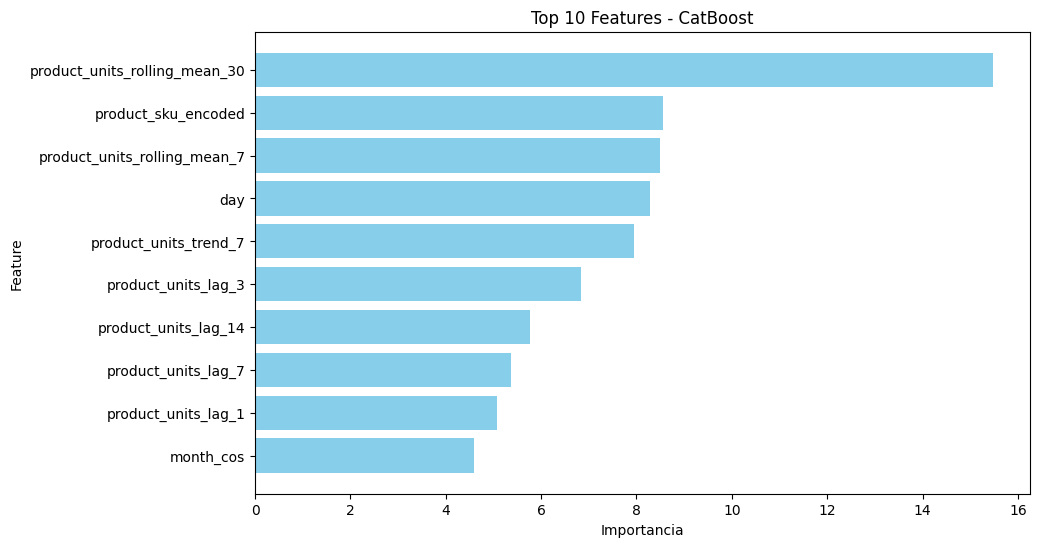

In [42]:
# 4. IMPORTANCIA DE FEATURES
import matplotlib.pyplot as plt
import pandas as pd

# Obtener importancia
feature_imp = cat_model.get_feature_importance(prettified=True)
print(feature_imp.head(10))

# Graficar top 10 features
top_features = feature_imp.head(10)
plt.figure(figsize=(10,6))
plt.barh(top_features['Feature Id'], top_features['Importances'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('Top 10 Features - CatBoost')
plt.gca().invert_yaxis()
plt.show()


### Conclusión: Experimento 3 - CatBoost

**Resultados obtenidos:**
- MAE  : ~2.77  
- RMSE : ~4.11  

**Observaciones:**
- CatBoost logra el **menor MAE y RMSE** entre los tres modelos experimentados, indicando que es el más preciso para predecir la demanda a nivel día/producto/transacción.  
- La importancia de features muestra que las variables más relevantes son:
  - `product_units_rolling_mean_30` → Promedio de unidades vendidas en los últimos 30 días.
  - `product_sku_encoded` → Identidad del producto.
  - `product_units_rolling_mean_7` → Promedio de la última semana.
  - `day` → Día del mes.
  - `product_units_trend_7` → Tendencia de la última semana.
- Las variables de **lags individuales** también aportan, pero CatBoost combina mejor la información de tendencias y promedios históricos.  
- Este modelo es robusto frente a datos granulares y puede integrarse en el **pipeline de entrenamiento y predicción** como la mejor opción hasta ahora.


## Comparación de Modelos de Predicción de Demanda

En este notebook se evaluaron tres modelos para predecir la demanda a nivel **día/producto/transacción**:

| Modelo             | MAE   | RMSE  | Observaciones |
|-------------------|-------|-------|---------------|
| Random Forest      | 3.04  | 4.22  | Buen desempeño general; captura patrones complejos, pero no aprovecha la información temporal de manera explícita. |
| LightGBM           | 2.84  | 4.22  | Ligera mejora en MAE respecto a Random Forest; eficiente y rápido; captura tendencias temporales con features de lag y rolling mean. |
| CatBoost           | 2.77  | 4.11  | Mejor desempeño general (menor MAE y RMSE); robusto frente a datos granulares; combina información de historial, tendencias y producto; manejo eficiente de variables categóricas. |

### Conclusión

- Todos los modelos basados en machine learning funcionan bien para predecir la demanda.  
- **CatBoost** logra el **menor error medio absoluto (MAE)** y el **menor RMSE**, mostrando mayor precisión y robustez frente a la granularidad del dataset.  
- Por estas razones, se **selecciona CatBoost como modelo final** para integrarlo en el pipeline de entrenamiento y predicción.
